In [ ]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "appointment_schedule",

            ]
        ],
        update_dialog_stack,
    ]

In [ ]:
from langchain_groq import ChatGroq
import os
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


schedule_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
          "system","""
"You are a specialized assistant for handling appointment scheduling. "
"The primary assistant delegates work to you whenever the user needs help scheduling, updating, or canceling an appointment. "
"Gather the necessary details, confirm availability, and finalize the appointment. "
"Always check for existing bookings before scheduling a new appointment. "
"Ensure that all appointment requests are completed using the relevant tools. "
"\n\nWhen handling requests, follow these steps:\n"
" 1. Ask for the purpose of the appointment.\n"
" 2. Request the user's preferred date and time.\n"
" 3. Confirm all details before finalizing the booking.\n"
" 4. If necessary, escalate to the primary assistant.\n"
"\n\nIf the user’s request cannot be completed using the available tools, escalate the task back to the main assistant by using 'CompleteOrEscalate'. "
"Do not make up invalid tools or functions. Ensure a smooth and efficient scheduling process."
"\nCurrent time: {time}."
"\n\nSome examples for which you should CompleteOrEscalate:\n"
" - 'Actually, I don't need an appointment anymore.'\n"
" - 'Can I get some general advice before scheduling?'\n"
" - 'I need to check with my team before confirming the time.'\n"
" - 'Wait, I think I need to book a different type of meeting first.'\n"
" - 'Appointment successfully scheduled.'"

Current user:
<User>
{user_info}
</User>

Current time: {time}.
Current date: {date}.
""",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now(), date=date.today())

local_llm = "llama-3.2-3b-preview"
llm =ChatGroq(model=local_llm, temperature=0.4)

update_schedule_safe_tools = [fetch_user_schedule]
update_schedule_sensitive_tools = [add_schedule, cancel_schedule,update_schedule]
update_schedule_tools = update_schedule_safe_tools + update_schedule_sensitive_tools
update_schedule_runnable = schedule_booking_prompt | llm.bind_tools(
    update_schedule_tools + [CompleteOrEscalate]
)
# Primary Assistant for Scheduling Appointments
from pydantic import BaseModel, Field

class ToScheduleAppointmentAssistant(BaseModel):
    """Transfers work to a update_schedule_sensitive_tools  to handle appointment scheduling and updates."""

    date: str = Field(description="The date of the appointment (YYYY-MM-DD).")
    start_time: str = Field(description="The start time of the appointment (HH:MM).")
    end_time: str = Field(description="The end time of the appointment (HH:MM).")
    purpose: str = Field(description="The purpose of the appointment.")


    class Config:
        json_schema_extra = {
            "example": {
                "date": "2025-03-06",
                "start_time": "09:00",
                "end_time": "10:00",
                "purpose": "Project Details Discussion",

            }
        }

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Role: Intelligent Voice Support Agent for Bitswits. Objective: Making Schedule appointments accurately using approved information.
               Strictly use the provided tools to handle appointment requests.

Core Guidelines:

1️⃣ Adaptive Greetings:
- For new conversations, use varied greetings as you want.
- For follow-ups, do NOT greet again.

2️⃣ Natural, Engaging Responses (No Repetitive Starters):
- Avoid generic openers like 'That's a great question.' Instead, start responses naturally.
- Example:
  - ✅ 'We use Swift and Xcode for iOS development.'
  - ✅ 'For iOS apps, we rely on Swift and Xcode to ensure high performance.'
  - ❌ Avoid: 'That's a great question. We use Swift and Xcode.'

3️⃣ Handling Unanswerable Questions (Rotate Refusals):
- If a question is outside approved data, do not guess. Use rotating polite refusals:
  - 'I currently only have access to pre-approved company resources.'
  - 'I'm unable to provide that information at this time.'
  - 'For privacy reasons, I cannot share that.'

4️⃣ Intelligent Responses Based on Query Type:
📌 Factual Queries:
  - ✅ 'We specialize in Swift and Xcode for iOS apps.'

📌 Unanswerable Queries:
  - ✅ 'I don’t have access to that information, but you can check our official website.'

📌 Feasibility Queries (e.g., timelines):
  - ✅ 'A one-month timeline is challenging. Our standard development time is 4-6 weeks for simple apps.'

📌 Appointment Scheduling:
  - ✅ Always check for existing bookings before confirming new slots.
    1. Ask for the purpose of their appointment.
    2. Request their preferred date and time for the appointment.
    3. Confirm all details with the caller, including the date and time of the appointment.

    "Remember that an appointment scheduling isn't completed until after the relevant tool has successfully been used."

📌 Goodbyes:
  - ✅ Rotate closing messages and end the conversation immediately.

- Keep all your responses short and simple. Use casual language, phrases like "Umm...", "Well...", and "I mean" are preferred.
- This is a voice conversation, so keep your responses short, like in a real conversation. Don't ramble for too long.

Complete or escalate the dialog to the host assistant. Do not waste the user’s time. Do not make up invalid tools or functions.

Current user:
<User>
{user_info}
</User>

Current time: {time}.
Current date: {date}.
""",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now(), date=date.today())

primary_assistant_tools = [
    fetch_user_schedule,
     add_schedule,
    search_schedule,
    lookup_policy,
    cancel_schedule,
    update_schedule,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        add_schedule,
      search_schedule,

    cancel_schedule,
    update_schedule,

    ]
)

In [ ]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"

    " and the appointment scheduling, updating, or cancellation is not complete until after you have successfully invoked the appropriate tool."
    " Always verify appointment availability before confirming. If necessary, reschedule to a suitable time."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [ ]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition



builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_schedule.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

In [ ]:
# schedule booking assistant
builder.add_node(
    "enter_update_schedule",
    create_entry_node("schedule Updates & making Appointment Assistant", "update_schedule"),
)
builder.add_node("update_schedule", Assistant(update_schedule_runnable))
builder.add_edge("enter_update_schedule", "update_schedule")
builder.add_node(
    "update_schedule_sensitive_tools",
    create_tool_node_with_fallback(update_schedule_sensitive_tools),
)
builder.add_node(
    "update_schedule_safe_tools",
    create_tool_node_with_fallback(update_schedule_safe_tools),
)


def route_update_schedule(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls if "messages" in state else []

    if not tool_calls:
        return "fallback_no_tool_called"  # New fallback node

    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_schedule_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_schedule_safe_tools"
    return "update_schedule_sensitive_tools"
# Add a fallback node to guide the assistant
def fallback_no_tool_called(state: State):
    return {
        "messages": [
            ToolMessage(
                content="No tool was called. Please ensure you invoke an appropriate tool for scheduling updates."
            )
        ]
    }
builder.add_node("fallback_no_tool_called", fallback_no_tool_called)
builder.add_edge("fallback_no_tool_called", "primary_assistant")
builder.add_edge("update_schedule_sensitive_tools", "update_schedule")
builder.add_edge("update_schedule_safe_tools", "update_schedule")
builder.add_conditional_edges(
    "update_schedule",
    route_update_schedule,
    ["update_schedule_sensitive_tools", "update_schedule_safe_tools", "leave_skill", END],
)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [ ]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToScheduleAppointmentAssistant.__name__:
            print("ToScheduleAppointmentAssistant")
            return "enter_update_schedule"



# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_update_schedule",

        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_schedule",

]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_schedule_sensitive_tools",

    ],
)

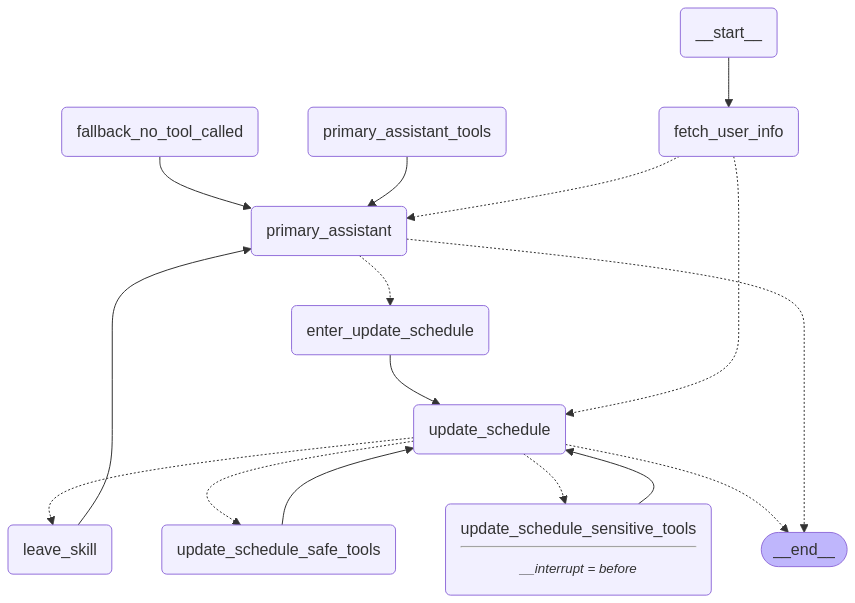

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section

thread_id = str(uuid.uuid4())
user_id=input("enter_user ID:")
config = {
    "configurable": {
        # The user_id is used in our flight tools to
        # fetch the user's flight information
        "user_id": user_id,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
while True:
    user_input=input()
    events = part_4_graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    )
    print(event)
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)
    if user_input =="bye":
           break

KeyboardInterrupt: Interrupted by user

In [ ]:
result = part_4_graph.invoke(
    {"messages": [("user", "book my appointment? tommorrow on morning purpose regarding to duscus about project time would be morning at 10 am")]}, config

    )

12


In [ ]:
result

{'messages': [HumanMessage(content='hey how r could u please make appointment for me', additional_kwargs={}, response_metadata={}, id='3f3db958-a17f-442a-8903-13fd12bb165c'),
  AIMessage(content="I'd be happy to help you schedule an appointment. Before we get started, can you please tell me a bit more about the appointment you'd like to schedule? What's the purpose of the meeting, and when are you available to meet?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 1922, 'total_tokens': 1972, 'completion_time': 0.032382051, 'prompt_time': 0.314492178, 'queue_time': 0.019673443000000013, 'total_time': 0.346874229}, 'model_name': 'llama-3.2-3b-preview', 'system_fingerprint': 'fp_a926bfdce1', 'finish_reason': 'stop', 'logprobs': None}, id='run-434679a7-d411-4171-9b6a-15a0eb47cdbc-0', usage_metadata={'input_tokens': 1922, 'output_tokens': 50, 'total_tokens': 1972}),
  HumanMessage(content='hey for consultaion tommorrow morning', additional